### 0. Standard setup for logging and plotting inside a notebook

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
root = logging.getLogger()
root.addHandler(logging.StreamHandler())
%matplotlib inline

### 1. Choose a representative species for a case study

In [2]:
# download from Google Drive: https://drive.google.com/open?id=0B9cazFzBtPuCOFNiUHYwcVFVODQ
# Representative example with multiple polygons in the shapefile, and a lot of point-records (also outside rangemaps)
from iSDM.species import IUCNSpecies
salmo_trutta = IUCNSpecies(name_species='Salmo trutta')
salmo_trutta.load_shapefile("../data/fish/selection/salmo_trutta")

Enabled Shapely speedups for performance.
Loading data from: ../data/fish/selection/salmo_trutta
The shapefile contains data on 3 species areas.


### 2. Rasterize the species, to get a matrix of pixels

In [3]:
rasterized = salmo_trutta.rasterize(raster_file="./salmo_trutta_full.tif", pixel_size=0.5, all_touched=True)

RASTERIO: Data rasterized into file ./salmo_trutta_full.tif 
RASTERIO: Resolution: x_res=720 y_res=360


#### 2.1 Plot to get an idea

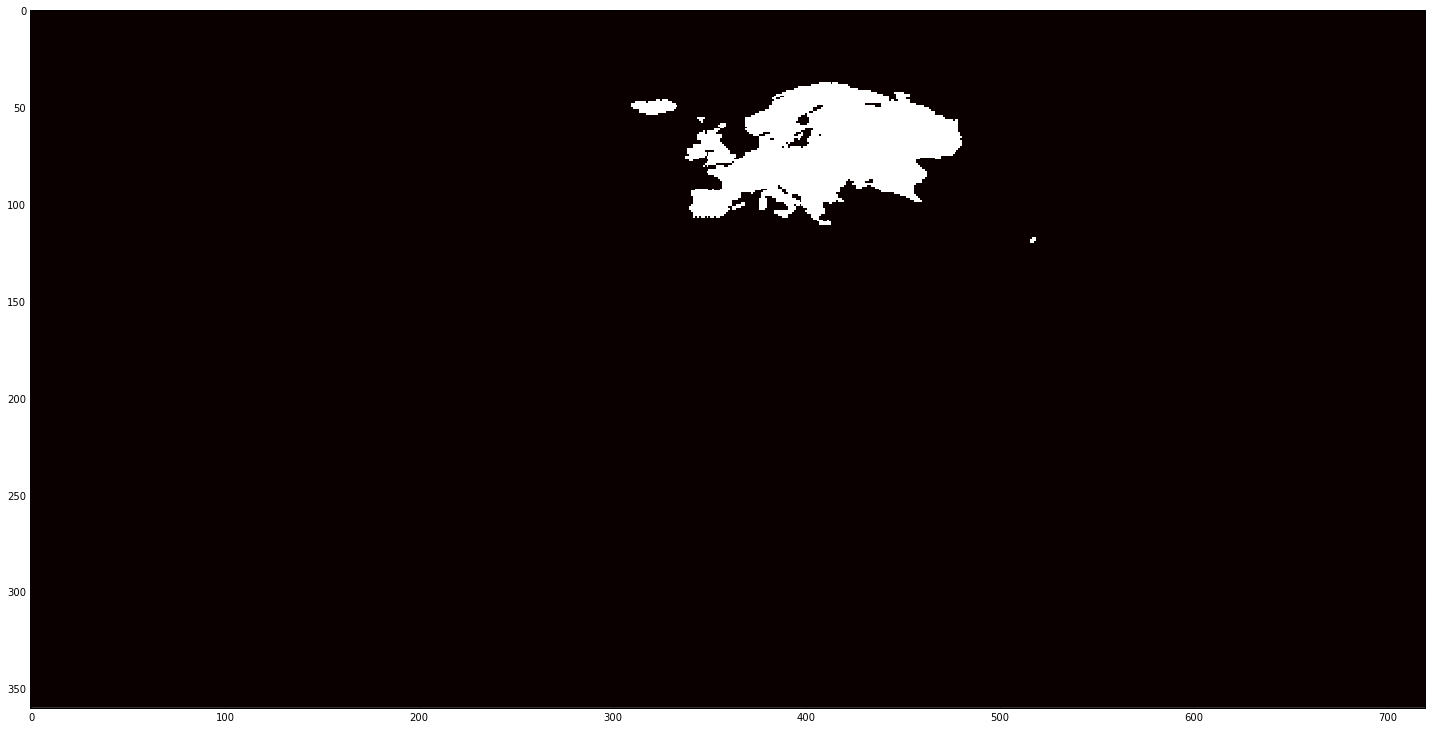

In [4]:
plt.figure(figsize=(25,20))
plt.imshow(rasterized, cmap="hot", interpolation="none")

### 3. Load the biogeographical regons raster layer

In [5]:
from iSDM.environment import RasterEnvironmentalLayer
biomes_adf = RasterEnvironmentalLayer(file_path="../data/rebioms/w001001.adf", name_layer="Biomes")
biomes_adf.load_data()

Loaded raster data from ../data/rebioms/w001001.adf 
Driver name: AIG 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'AIG',
 'dtype': 'uint8',
 'height': 360,
 'nodata': 255.0,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.


<open RasterReader name='../data/rebioms/w001001.adf' mode='r'>

#### 3.1 Plot to get an idea

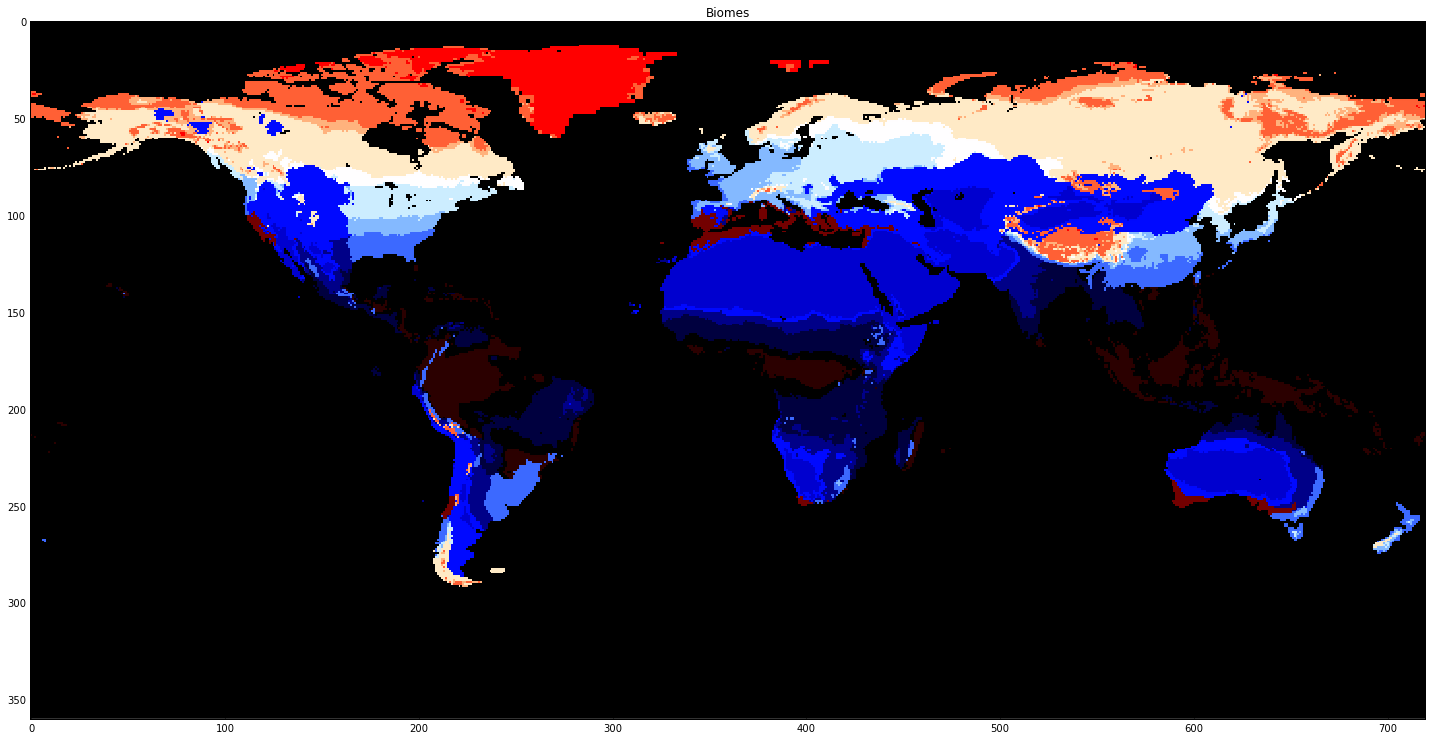

In [6]:
biomes_adf.plot()

### 3.2 Load the continents vector layer (for further clipping of pseudo-absence area), rasterize

Loading data from ../data/continents/continent.shp 
The shapefile contains data on 8 environmental regions.


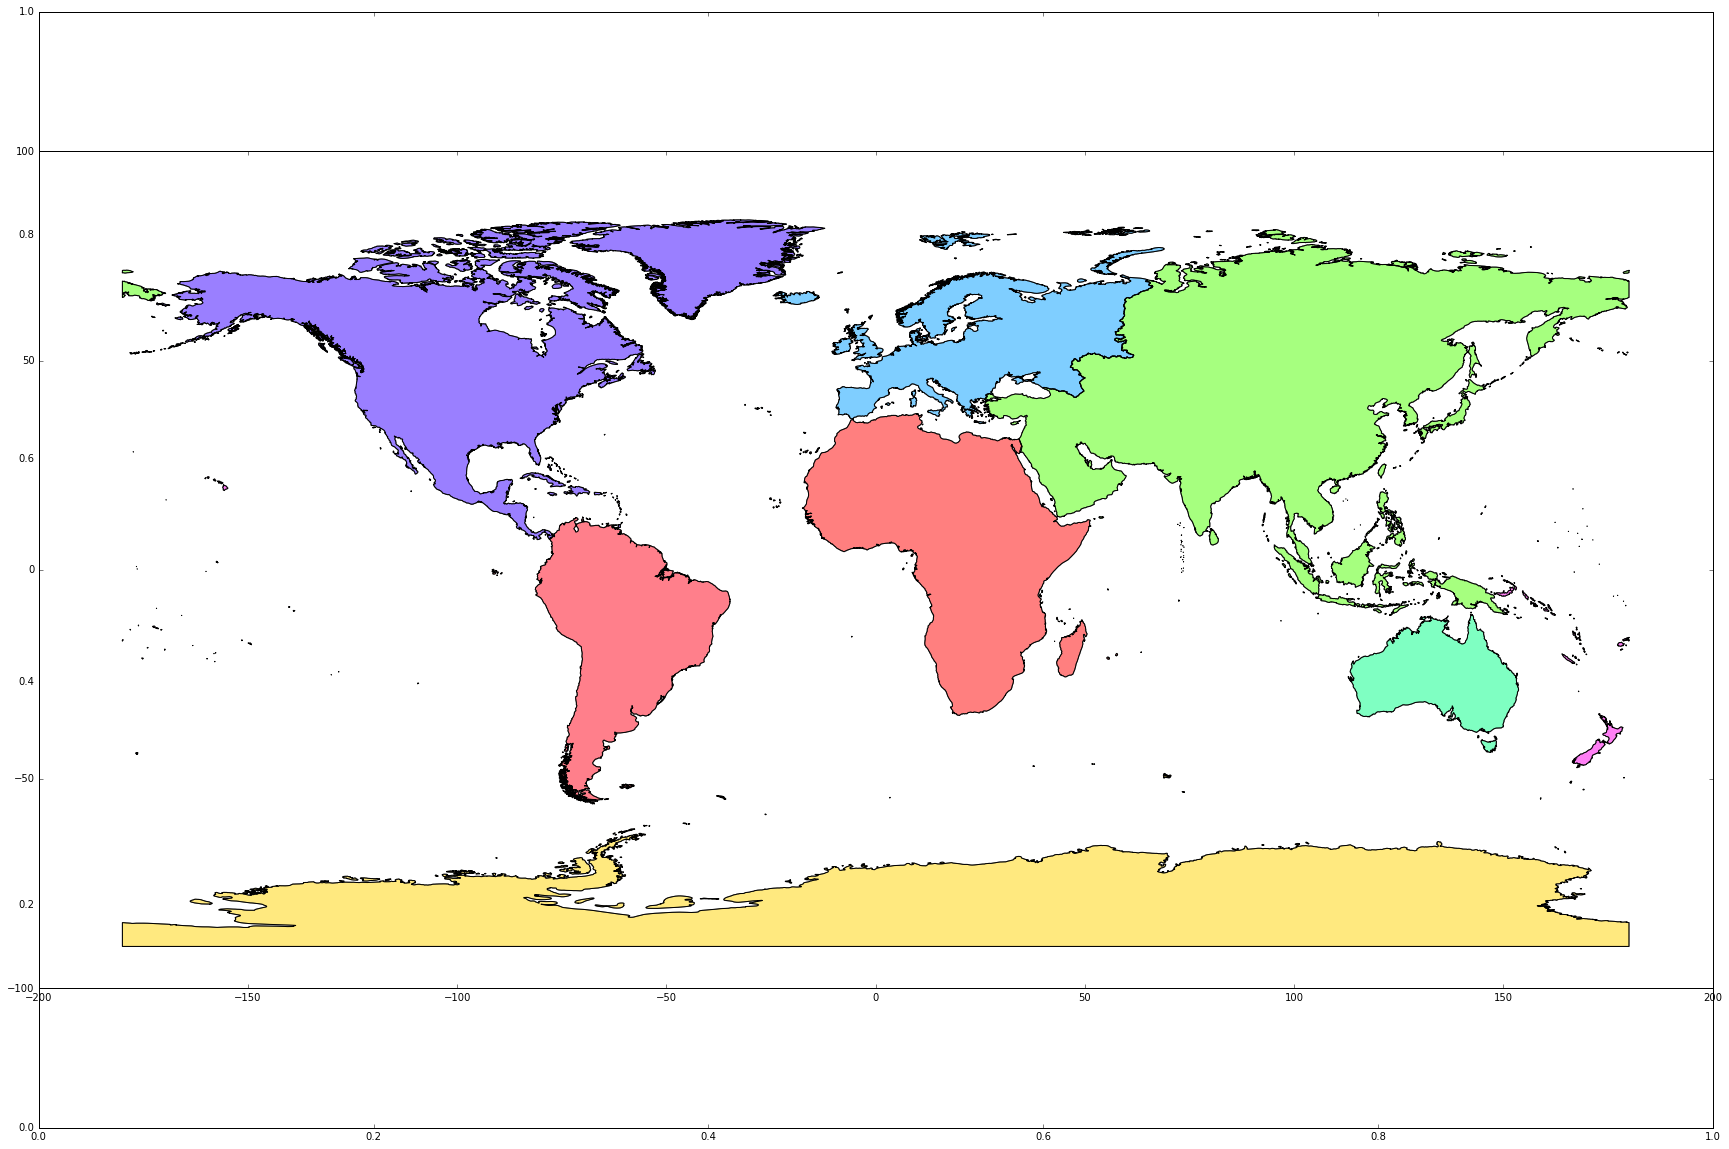

In [7]:
from iSDM.environment import ContinentsLayer
from iSDM.environment import Source
continents = ContinentsLayer(file_path="../data/continents/continent.shp", source=Source.ARCGIS)
continents.load_data()
fig, ax = plt.subplots(1,1, figsize=(30,20))
continents.data_full.plot(column="continent", colormap="hsv")

In [8]:
continents_rasters = continents.rasterize(raster_file="../data/continents/continents_raster.tif", pixel_size=0.5, all_touched=True)

Will rasterize continent-by-continent.
Rasterizing continent Asia 
Rasterizing continent North America 
Rasterizing continent Europe 
Rasterizing continent Africa 
Rasterizing continent South America 
Rasterizing continent Oceania 
Rasterizing continent Australia 
Rasterizing continent Antarctica 
RASTERIO: Data rasterized into file ../data/continents/continents_raster.tif 
RASTERIO: Resolution: x_res=720 y_res=360


In [9]:
continents_rasters.shape # stacked raster with 8 bands, one for each continent.

(8, 360, 720)

As agreed, we will merge Europe and Asia to be a bit closer to the biogeographical regions. We do this user-specific patching for now, until a better solution is found.

In [10]:
continents_rasters[0] = continents_rasters[0] + continents_rasters[2] # combine Europe and Asia

In [11]:
continents_rasters[0].max() # where the continents touch, we have overlap! that's why max is not 1, but 2.

2

Set all values >1 to 1. (we only care about presence/absence)

In [13]:
continents_rasters[0][continents_rasters[0] > 1] = 1

Delete band 2 (Europe, previously merged with layer 0==Asia)

In [14]:
continents_rasters = np.delete(continents_rasters, 2, 0)

This is how the band 0 looks like now.

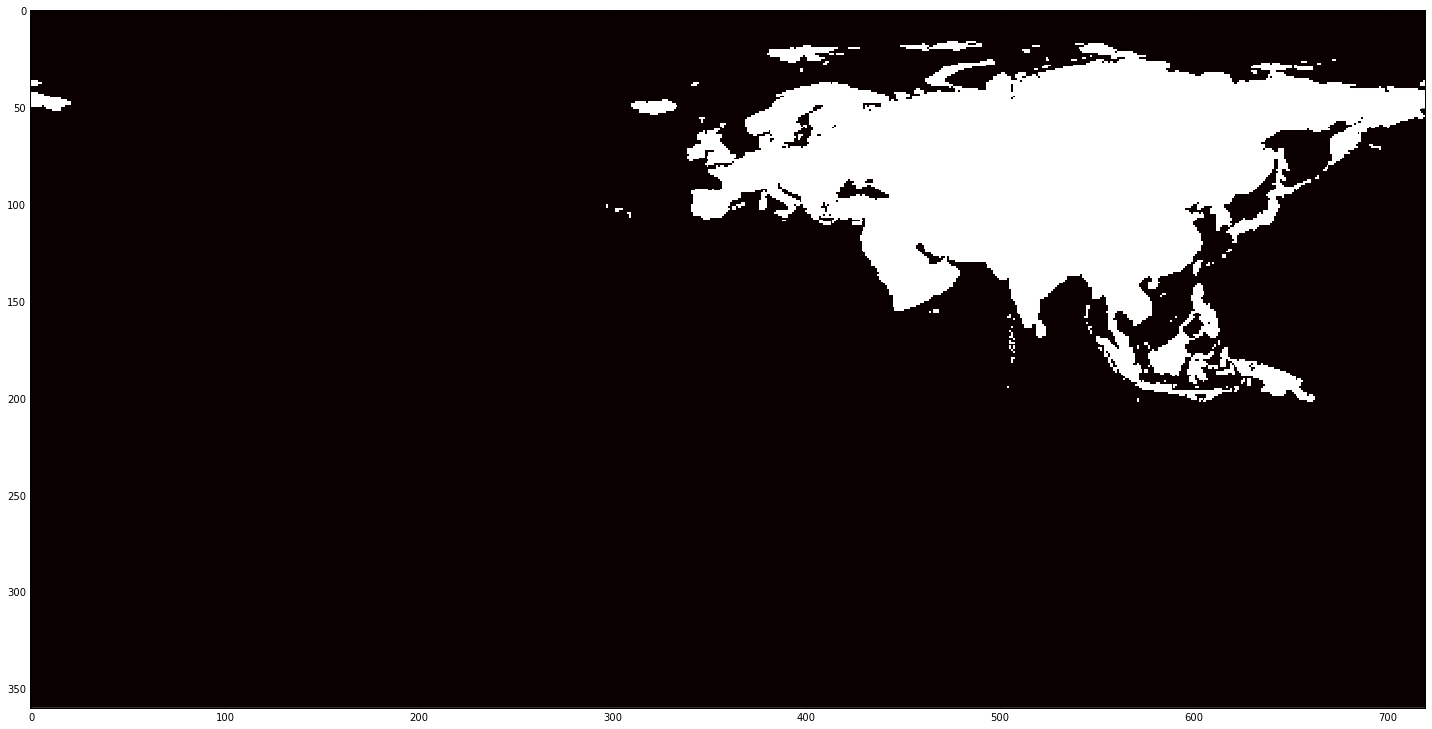

In [15]:
plt.figure(figsize=(25,20))
plt.imshow(continents_rasters[0], cmap="hot", interpolation="none")

In [16]:
continents_rasters.shape # now total of 7 band rather than 8

(7, 360, 720)

### 4. Sample pseudo-absence pixels, taking into account all the distinct biomes that fall in the species region.

In [17]:
selected_layers, pseudo_absences = biomes_adf.sample_pseudo_absences(species_raster_data=rasterized,continents_raster_data=continents_rasters, number_of_pseudopoints=1000)

Succesfully loaded existing raster data from ../data/rebioms/w001001.adf.
Will use the continents/biogeographic raster data for further clipping of the pseudo-absence regions. 
Sampling 1000 pseudo-absence points from environmental layer.
The following unique (pixel) values will be taken into account for sampling pseudo-absences
[ 8  9 10 11 12 13 14 15 17 21]
There are 17842 pixels to sample from...
Filling 1000 random pixel positions...
Sampled 971 unique pixels as pseudo-absences.


#### 4.1 Plot the biomes taken into account for sampling pseudo-absences, to get an idea

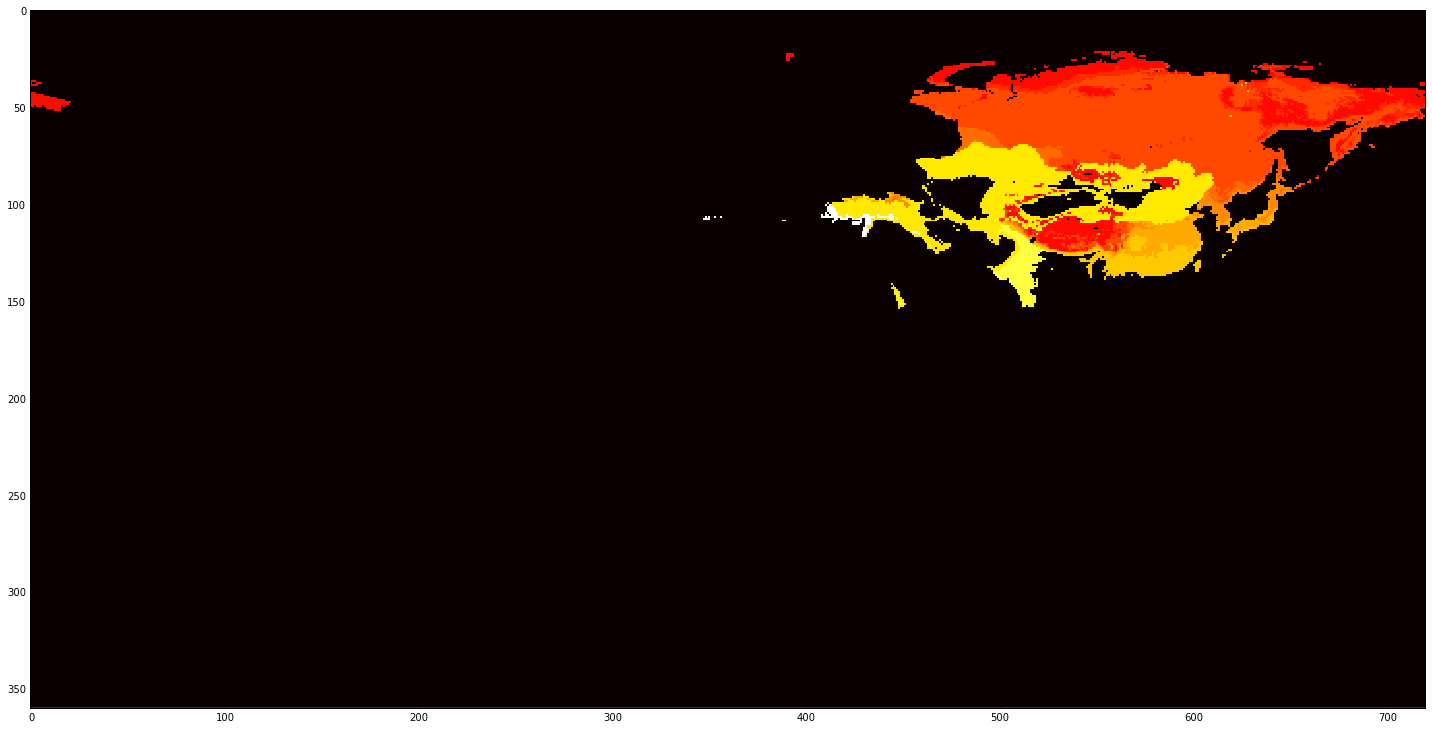

In [18]:
plt.figure(figsize=(25,20))
plt.imshow(selected_layers, cmap="hot", interpolation="none")

#### 4.2 Plot the sampled pseudo-absences, to get an idea

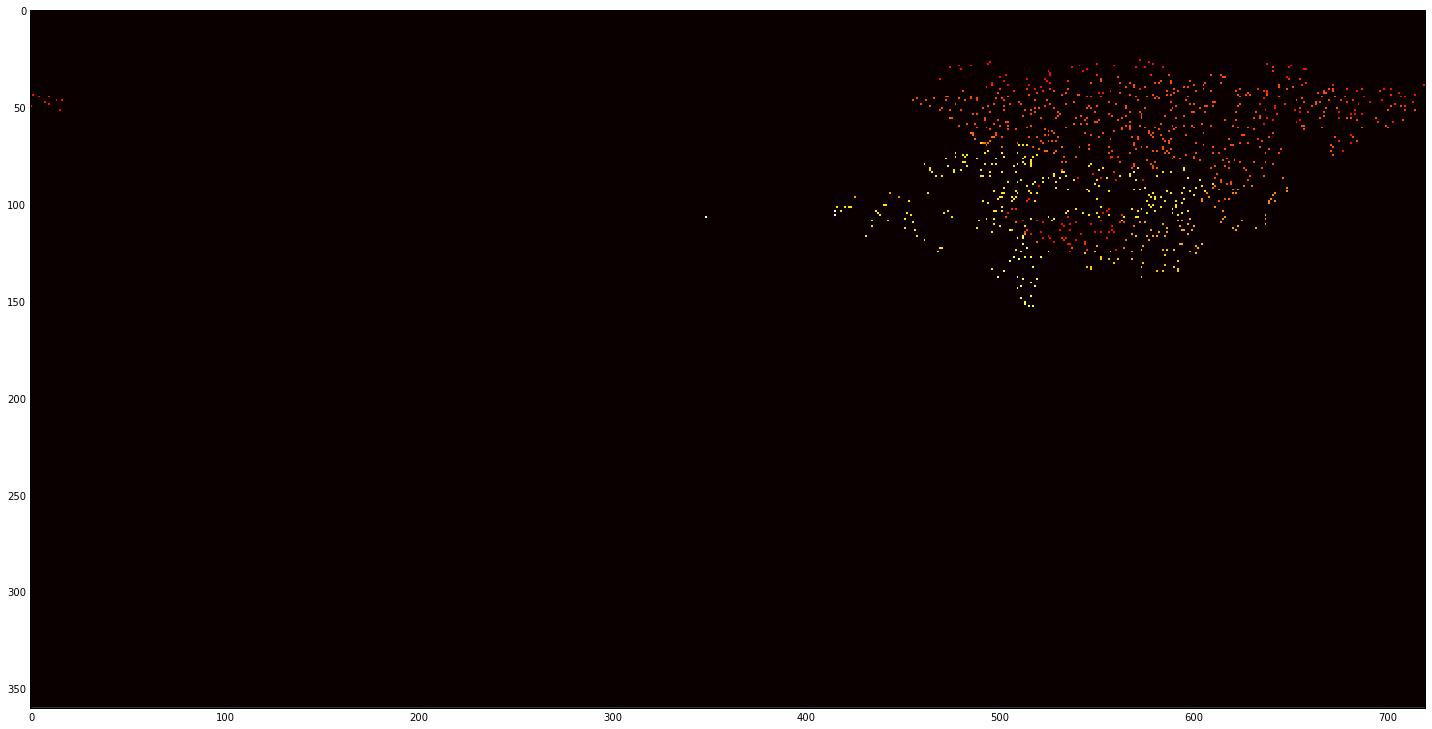

In [19]:
plt.figure(figsize=(25,20))
plt.imshow(pseudo_absences, cmap="hot", interpolation="none")

### 5. Construct a convenient dataframe for testing with different SDM models
For the Example 2 datasheet, all cells of a global raster map are needed, one pixel per row.

#### 5.1 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a "base" (zeroes) raster map. 

In [20]:
all_coordinates = biomes_adf.pixel_to_world_coordinates(raster_data=np.zeros_like(rasterized), filter_no_data_value=False)

Transforming to world coordinates...
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Not filtering any no_data pixels.
Transformation to world coordinates completed.


In [21]:
all_coordinates

(array([ 89.75,  89.75,  89.75, ..., -89.75, -89.75, -89.75]),
 array([-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75]))

In [22]:
base_dataframe = pd.DataFrame([all_coordinates[0], all_coordinates[1]]).T
base_dataframe.columns=['decimallatitude', 'decimallongitude']
base_dataframe.set_index(['decimallatitude', 'decimallongitude'], inplace=True, drop=True)

In [23]:
base_dataframe.head()

Empty DataFrame
Columns: []
Index: [(89.75, -179.75), (89.75, -179.25), (89.75, -178.75), (89.75, -178.25), (89.75, -177.75)]

In [24]:
base_dataframe.tail()

Empty DataFrame
Columns: []
Index: [(-89.75, 177.75), (-89.75, 178.25), (-89.75, 178.75), (-89.75, 179.25), (-89.75, 179.75)]

#### 5.2 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a presences pixel map

In [25]:
presence_coordinates = salmo_trutta.pixel_to_world_coordinates()

No raster data provided, attempting to load default...
Loaded raster data from ./salmo_trutta_full.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 360,
 'nodata': 0.0,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
Succesfully loaded existing raster data from ./salmo_trutta_full.tif.
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.


In [26]:
presence_coordinates

(array([ 71.25,  71.25,  71.25, ...,  30.75,  30.25,  30.25]),
 array([ 23.75,  24.25,  24.75, ...,  79.25,  78.25,  78.75]))

In [27]:
presences_dataframe = pd.DataFrame([presence_coordinates[0], presence_coordinates[1]]).T
presences_dataframe.columns=['decimallatitude', 'decimallongitude']
presences_dataframe[salmo_trutta.name_species] = 1 # fill presences with 1's
presences_dataframe.set_index(['decimallatitude', 'decimallongitude'], inplace=True, drop=True)
presences_dataframe.head()

Salmo trutta
decimallatitude decimallongitude              
71.25           23.75                        1
                24.25                        1
                24.75                        1
                25.25                        1
                25.75                        1

In [28]:
presences_dataframe.tail()

Salmo trutta
decimallatitude decimallongitude              
30.75           78.25                        1
                78.75                        1
                79.25                        1
30.25           78.25                        1
                78.75                        1

#### 5.3 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a pseudo_absences pixel map

In [29]:
pseudo_absence_coordinates = biomes_adf.pixel_to_world_coordinates(raster_data=pseudo_absences)

Transforming to world coordinates...
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.
Transformation to world coordinates completed.


In [30]:
pseudo_absences_dataframe = pd.DataFrame([pseudo_absence_coordinates[0], pseudo_absence_coordinates[1]]).T
pseudo_absences_dataframe.columns=['decimallatitude', 'decimallongitude']
pseudo_absences_dataframe[salmo_trutta.name_species] = 0 # fill pseudo-absences with 0
pseudo_absences_dataframe.set_index(['decimallatitude', 'decimallongitude'], inplace=True, drop=True)

In [31]:
pseudo_absences_dataframe.head()

Salmo trutta
decimallatitude decimallongitude              
77.25           106.25                       0
76.75           67.75                        0
                108.75                       0
76.25           67.25                        0
                95.25                        0

In [32]:
pseudo_absences_dataframe.tail()

Salmo trutta
decimallatitude decimallongitude              
15.75           75.75                        0
14.75           76.75                        0
14.25           76.75                        0
13.75           77.75                        0
                78.75                        0

#### 5.4 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a minimum temperature pixel map

In [33]:
from iSDM.environment import ClimateLayer
water_min_layer =  ClimateLayer(file_path="../data/watertemp/min_wt_2000.tif") 
water_min_reader = water_min_layer.load_data()
# HERE: should we ignore cells with no-data values for temperature? They are set to a really big negative number
# for now we keep them, otherwise could be NaN
water_min_coordinates = water_min_layer.pixel_to_world_coordinates(filter_no_data_value=False)

Loaded raster data from ../data/watertemp/min_wt_2000.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 360,
 'nodata': -3.402823e+38,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
No raster data provided, attempting to load default...
Loaded raster data from ../data/watertemp/min_wt_2000.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 360,
 'nodata': -3.402823e+38,
 'transform': (-180.

In [34]:
water_min_coordinates

(array([ 89.75,  89.75,  89.75, ..., -89.75, -89.75, -89.75]),
 array([-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75]))

In [35]:
mintemp_dataframe = pd.DataFrame([water_min_coordinates[0], water_min_coordinates[1]]).T
mintemp_dataframe.columns=['decimallatitude', 'decimallongitude']
water_min_matrix = water_min_reader.read(1)
mintemp_dataframe['MinT'] = water_min_matrix.reshape(np.product(water_min_matrix.shape))
mintemp_dataframe.set_index(['decimallatitude', 'decimallongitude'], inplace=True, drop=True)
mintemp_dataframe.head()

MinT
decimallatitude decimallongitude              
89.75           -179.75          -3.402823e+38
                -179.25          -3.402823e+38
                -178.75          -3.402823e+38
                -178.25          -3.402823e+38
                -177.75          -3.402823e+38

In [36]:
mintemp_dataframe.tail()

MinT
decimallatitude decimallongitude              
-89.75          177.75           -3.402823e+38
                178.25           -3.402823e+38
                178.75           -3.402823e+38
                179.25           -3.402823e+38
                179.75           -3.402823e+38

#### 5.5 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a maximum temperature pixel map

In [37]:
water_max_layer =  ClimateLayer(file_path="../data/watertemp/max_wt_2000.tif") 
water_max_reader = water_max_layer.load_data()
# HERE: should we ignore cells with no-data values for temperature? They are set to a really big negative number
# for now we keep them, otherwise could be NaN
water_max_coordinates = water_max_layer.pixel_to_world_coordinates(filter_no_data_value=False)

Loaded raster data from ../data/watertemp/max_wt_2000.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 360,
 'nodata': -3.402823e+38,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
No raster data provided, attempting to load default...
Loaded raster data from ../data/watertemp/max_wt_2000.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 360,
 'nodata': -3.402823e+38,
 'transform': (-180.

In [38]:
maxtemp_dataframe = pd.DataFrame([water_max_coordinates[0], water_max_coordinates[1]]).T
maxtemp_dataframe.columns=['decimallatitude', 'decimallongitude']
water_max_matrix = water_max_reader.read(1)
maxtemp_dataframe['MaxT'] = water_max_matrix.reshape(np.product(water_max_matrix.shape))
maxtemp_dataframe.set_index(['decimallatitude', 'decimallongitude'], inplace=True, drop=True)
maxtemp_dataframe.head()

MaxT
decimallatitude decimallongitude              
89.75           -179.75          -3.402823e+38
                -179.25          -3.402823e+38
                -178.75          -3.402823e+38
                -178.25          -3.402823e+38
                -177.75          -3.402823e+38

In [39]:
maxtemp_dataframe.tail()

MaxT
decimallatitude decimallongitude              
-89.75          177.75           -3.402823e+38
                178.25           -3.402823e+38
                178.75           -3.402823e+38
                179.25           -3.402823e+38
                179.75           -3.402823e+38

#### 5.6 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a mean temperature pixel map

In [40]:
water_mean_layer =  ClimateLayer(file_path="../data/watertemp/mean_wt_2000.tif") 
water_mean_reader = water_mean_layer.load_data()
# HERE: should we ignore cells with no-data values for temperature? They are set to a really big negative number
# for now we keep them, otherwise could be NaN
water_mean_coordinates = water_mean_layer.pixel_to_world_coordinates(filter_no_data_value=False)

Loaded raster data from ../data/watertemp/mean_wt_2000.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 360,
 'nodata': -3.402823e+38,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
No raster data provided, attempting to load default...
Loaded raster data from ../data/watertemp/mean_wt_2000.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 360,
 'nodata': -3.402823e+38,
 'transform': (-18

In [41]:
meantemp_dataframe = pd.DataFrame([water_mean_coordinates[0], water_mean_coordinates[1]]).T
meantemp_dataframe.columns=['decimallatitude', 'decimallongitude']
water_mean_matrix = water_mean_reader.read(1)
meantemp_dataframe['MeanT'] = water_mean_matrix.reshape(np.product(water_mean_matrix.shape))
meantemp_dataframe.set_index(['decimallatitude', 'decimallongitude'], inplace=True, drop=True)
meantemp_dataframe.head()

MeanT
decimallatitude decimallongitude              
89.75           -179.75          -3.402823e+38
                -179.25          -3.402823e+38
                -178.75          -3.402823e+38
                -178.25          -3.402823e+38
                -177.75          -3.402823e+38

In [42]:
meantemp_dataframe.tail()

MeanT
decimallatitude decimallongitude              
-89.75          177.75           -3.402823e+38
                178.25           -3.402823e+38
                178.75           -3.402823e+38
                179.25           -3.402823e+38
                179.75           -3.402823e+38

In [44]:
# merge base with presences
merged = base_dataframe.combine_first(presences_dataframe)

In [45]:
merged.head()

Salmo trutta
decimallatitude decimallongitude              
-89.75          -179.75                    NaN
                -179.25                    NaN
                -178.75                    NaN
                -178.25                    NaN
                -177.75                    NaN

In [46]:
merged.tail()

Salmo trutta
decimallatitude decimallongitude              
89.75           177.75                     NaN
                178.25                     NaN
                178.75                     NaN
                179.25                     NaN
                179.75                     NaN

In [47]:
# merge based+presences with pseudo-absences
# merged2 = pd.merge(merged1, pseudo_absences_dataframe, on=["decimallatitude", "decimallongitude", salmo_trutta.name_species], how="outer")

merged = merged.combine_first(pseudo_absences_dataframe)

http://pandas.pydata.org/pandas-docs/stable/merging.html

For this, use the combine_first method.

Note that this method only takes values from the right DataFrame if they are missing in the left DataFrame. A related method, update, alters non-NA values inplace


In [48]:
merged.head()

Salmo trutta
decimallatitude decimallongitude              
-89.75          -179.75                    NaN
                -179.25                    NaN
                -178.75                    NaN
                -178.25                    NaN
                -177.75                    NaN

In [49]:
merged.tail()

Salmo trutta
decimallatitude decimallongitude              
89.75           177.75                     NaN
                178.25                     NaN
                178.75                     NaN
                179.25                     NaN
                179.75                     NaN

In [50]:
# merge base+presences+pseudo-absences with min temperature
#merged3 = pd.merge(merged2, mintemp_dataframe, on=["decimallatitude", "decimallongitude"], how="outer")

merged = merged.combine_first(mintemp_dataframe)

In [51]:
merged.head()

MinT  Salmo trutta
decimallatitude decimallongitude                            
-89.75          -179.75          -3.402823e+38           NaN
                -179.25          -3.402823e+38           NaN
                -178.75          -3.402823e+38           NaN
                -178.25          -3.402823e+38           NaN
                -177.75          -3.402823e+38           NaN

In [52]:
merged.tail()

MinT  Salmo trutta
decimallatitude decimallongitude                            
89.75           177.75           -3.402823e+38           NaN
                178.25           -3.402823e+38           NaN
                178.75           -3.402823e+38           NaN
                179.25           -3.402823e+38           NaN
                179.75           -3.402823e+38           NaN

In [53]:
# merged4 = pd.merge(merged3, maxtemp_dataframe, on=["decimallatitude", "decimallongitude"], how="outer")
merged = merged.combine_first(maxtemp_dataframe)

In [54]:
merged.head()

MaxT          MinT  Salmo trutta
decimallatitude decimallongitude                                          
-89.75          -179.75          -3.402823e+38 -3.402823e+38           NaN
                -179.25          -3.402823e+38 -3.402823e+38           NaN
                -178.75          -3.402823e+38 -3.402823e+38           NaN
                -178.25          -3.402823e+38 -3.402823e+38           NaN
                -177.75          -3.402823e+38 -3.402823e+38           NaN

In [55]:
merged.tail()

MaxT          MinT  Salmo trutta
decimallatitude decimallongitude                                          
89.75           177.75           -3.402823e+38 -3.402823e+38           NaN
                178.25           -3.402823e+38 -3.402823e+38           NaN
                178.75           -3.402823e+38 -3.402823e+38           NaN
                179.25           -3.402823e+38 -3.402823e+38           NaN
                179.75           -3.402823e+38 -3.402823e+38           NaN

In [56]:
# merged5 = pd.merge(merged4, meantemp_dataframe, on=["decimallatitude", "decimallongitude"], how="outer")
merged = merged.combine_first(meantemp_dataframe)

In [57]:
merged.tail()

MaxT         MeanT          MinT  \
decimallatitude decimallongitude                                             
89.75           177.75           -3.402823e+38 -3.402823e+38 -3.402823e+38   
                178.25           -3.402823e+38 -3.402823e+38 -3.402823e+38   
                178.75           -3.402823e+38 -3.402823e+38 -3.402823e+38   
                179.25           -3.402823e+38 -3.402823e+38 -3.402823e+38   
                179.75           -3.402823e+38 -3.402823e+38 -3.402823e+38   

                                  Salmo trutta  
decimallatitude decimallongitude                
89.75           177.75                     NaN  
                178.25                     NaN  
                178.75                     NaN  
                179.25                     NaN  
                179.75                     NaN

In [58]:
merged.to_csv("../data/fish/selection/salmo_trutta.csv")

In [59]:
merged[merged['Salmo trutta']==0].shape[0] # should be equal to number of pseudo absences below

971

In [60]:
pseudo_absence_coordinates[0].shape[0]

971

In [61]:
merged[merged['Salmo trutta']==1].shape[0]  # should be equal to number of presences below

6089

In [62]:
presence_coordinates[0].shape[0]

6089

In [63]:
merged[merged['Salmo trutta'].isnull()].shape[0] # all that's left

252140

In [64]:
360 * 720 == merged[merged['Salmo trutta']==0].shape[0] + merged[merged['Salmo trutta']==1].shape[0] + merged[merged['Salmo trutta'].isnull()].shape[0]

True

In [65]:
# == all pixels in 360 x 720 matrix

### 6. Repeat with other species

In [66]:
# Download from Google Drive: https://drive.google.com/open?id=0B9cazFzBtPuCaW0wRkk2N0g5d1k
lepidomeda_mollispinis = IUCNSpecies(name_species='Lepidomeda mollispinis')
lepidomeda_mollispinis.load_shapefile("../data/fish/selection/lepidomeda_mollispinis")

Enabled Shapely speedups for performance.
Loading data from: ../data/fish/selection/lepidomeda_mollispinis
The shapefile contains data on 1 species areas.


In [67]:
rasterized_lm = lepidomeda_mollispinis.rasterize(raster_file="./lepidomeda_mollispinis_full.tif", pixel_size=0.5, all_touched=True)

RASTERIO: Data rasterized into file ./lepidomeda_mollispinis_full.tif 
RASTERIO: Resolution: x_res=720 y_res=360


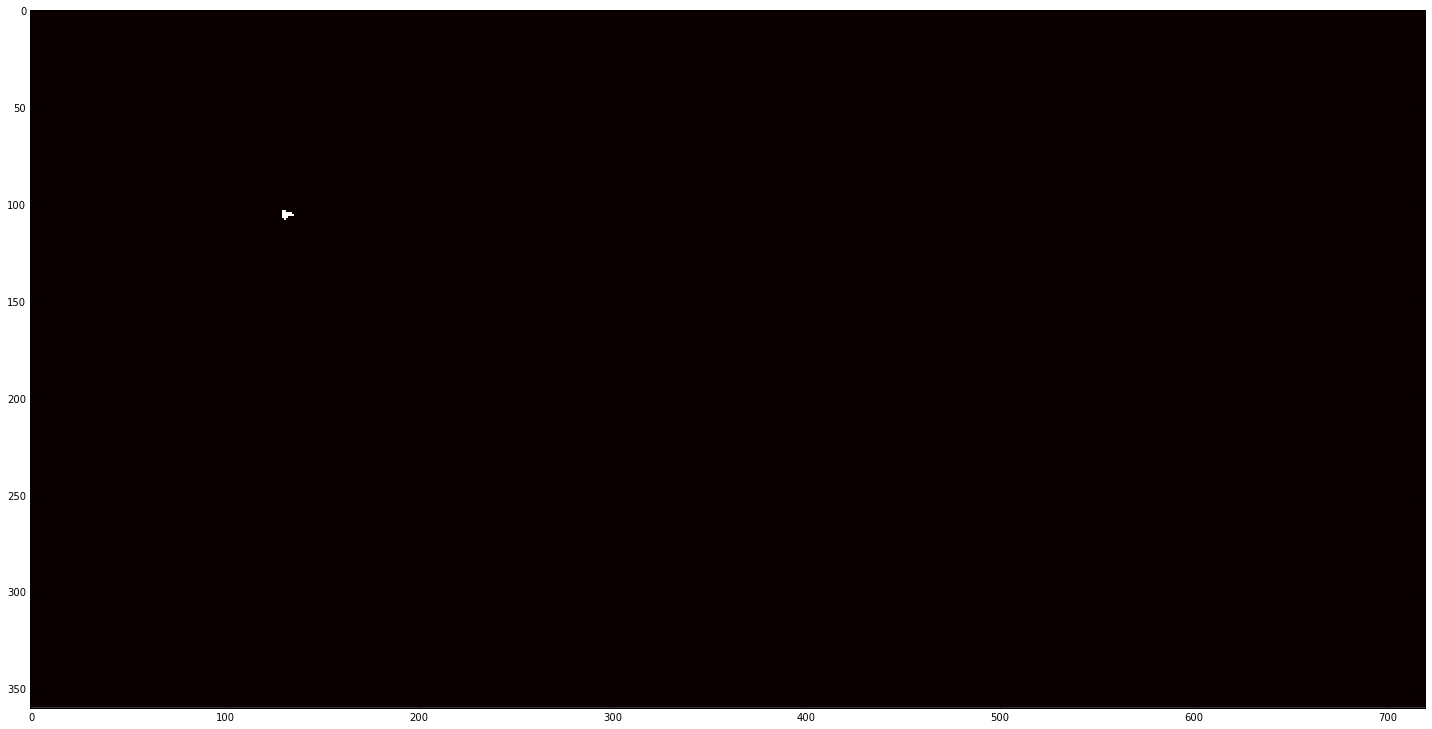

In [68]:
plt.figure(figsize=(25,20))
plt.imshow(rasterized_lm, cmap="hot", interpolation="none")

In [69]:
selected_layers_lm, pseudo_absences_lm = biomes_adf.sample_pseudo_absences(species_raster_data=rasterized_lm, continents_raster_data=continents_rasters, number_of_pseudopoints=1000)

Succesfully loaded existing raster data from ../data/rebioms/w001001.adf.
Will use the continents/biogeographic raster data for further clipping of the pseudo-absence regions. 
Sampling 1000 pseudo-absence points from environmental layer.
The following unique (pixel) values will be taken into account for sampling pseudo-absences
[15 16]
There are 1926 pixels to sample from...
Filling 1000 random pixel positions...
Sampled 777 unique pixels as pseudo-absences.


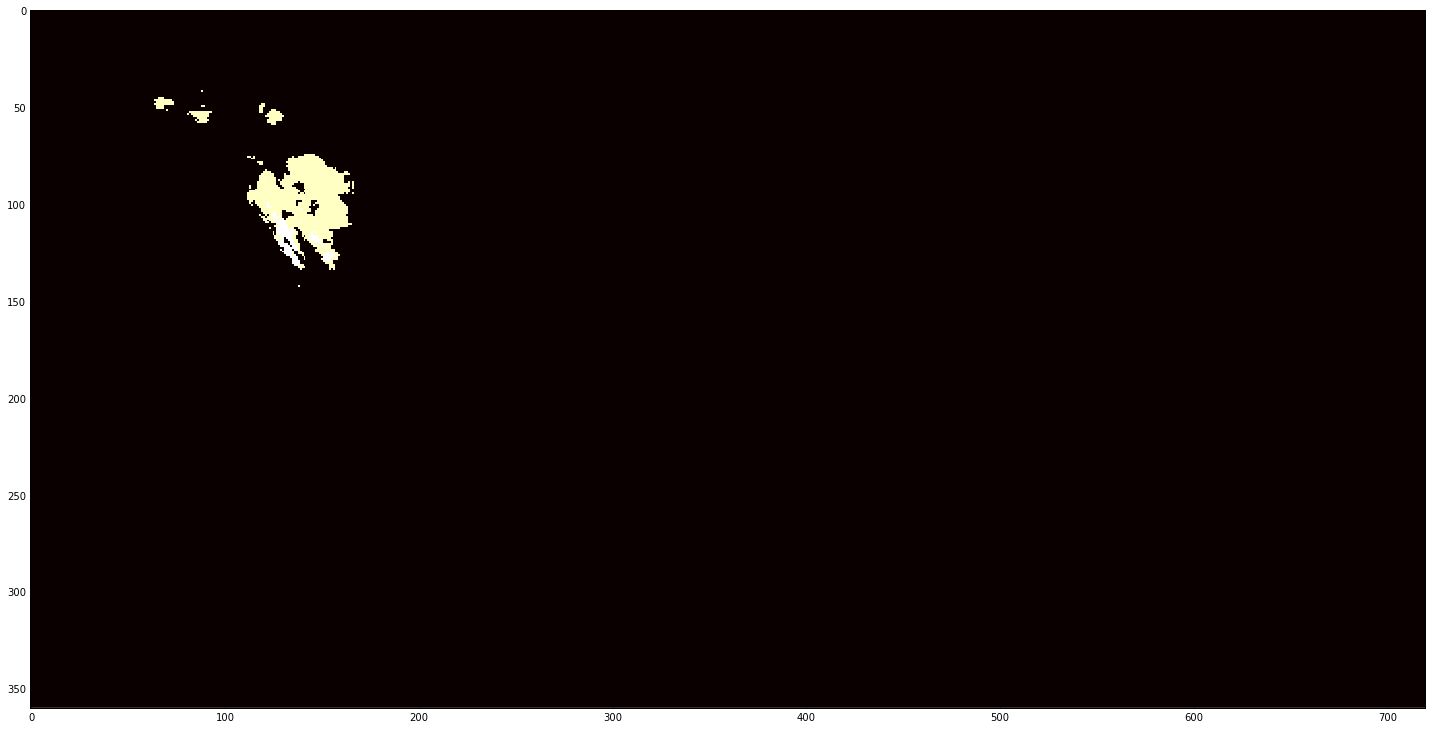

In [70]:
plt.figure(figsize=(25,20))
plt.imshow(selected_layers_lm, cmap="hot", interpolation="none")

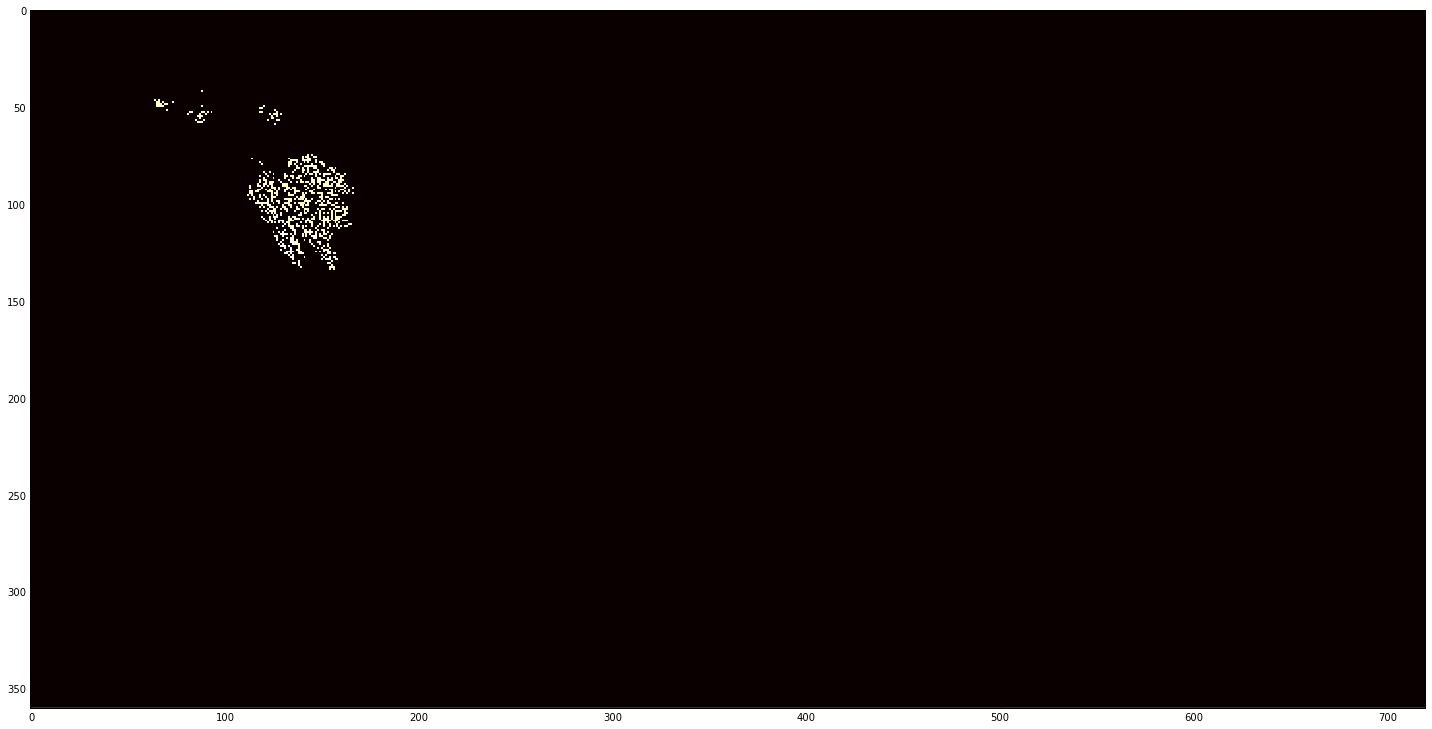

In [71]:
plt.figure(figsize=(25,20))
plt.imshow(pseudo_absences_lm, cmap="hot", interpolation="none")

In [72]:
presence_coordinates_lm = lepidomeda_mollispinis.pixel_to_world_coordinates()

No raster data provided, attempting to load default...
Loaded raster data from ./lepidomeda_mollispinis_full.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 360,
 'nodata': 0.0,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
Succesfully loaded existing raster data from ./lepidomeda_mollispinis_full.tif.
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no

In [73]:
presences_dataframe = pd.DataFrame([presence_coordinates_lm[0], presence_coordinates_lm[1]]).T
presences_dataframe.columns=['decimallatitude', 'decimallongitude']
presences_dataframe[lepidomeda_mollispinis.name_species] = 1 # fill presences with 1's
presences_dataframe.set_index(['decimallatitude', 'decimallongitude'], inplace=True, drop=True)
presences_dataframe.head()

Lepidomeda mollispinis
decimallatitude decimallongitude                        
38.25           -114.75                                1
                -114.25                                1
37.75           -114.75                                1
                -114.25                                1
                -113.75                                1

In [74]:
presences_dataframe.tail()

Lepidomeda mollispinis
decimallatitude decimallongitude                        
37.25           -112.25                                1
36.75           -114.75                                1
                -114.25                                1
                -113.75                                1
36.25           -114.25                                1

In [75]:
pseudo_absence_coordinates_lm = biomes_adf.pixel_to_world_coordinates(raster_data=pseudo_absences_lm)

Transforming to world coordinates...
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.
Transformation to world coordinates completed.


In [76]:
pseudo_absences_dataframe = pd.DataFrame([pseudo_absence_coordinates_lm[0], pseudo_absence_coordinates_lm[1]]).T
pseudo_absences_dataframe.columns=['decimallatitude', 'decimallongitude']
pseudo_absences_dataframe[lepidomeda_mollispinis.name_species] = 0
pseudo_absences_dataframe.set_index(['decimallatitude', 'decimallongitude'], inplace=True, drop=True)

In [77]:
pseudo_absences_dataframe.head()

Lepidomeda mollispinis
decimallatitude decimallongitude                        
69.25           -135.75                                0
66.75           -147.75                                0
                -146.75                                0
66.25           -147.25                                0
                -146.75                                0

In [78]:
pseudo_absences_dataframe.tail()

Lepidomeda mollispinis
decimallatitude decimallongitude                        
23.75           -102.75                                0
                -102.25                                0
                -101.75                                0
23.25           -102.75                                0
                -101.75                                0

In [79]:
merged1 = merged.combine_first(presences_dataframe)

In [80]:
merged1.tail()

Lepidomeda mollispinis          MaxT  \
decimallatitude decimallongitude                                         
89.75           177.75                               NaN -3.402823e+38   
                178.25                               NaN -3.402823e+38   
                178.75                               NaN -3.402823e+38   
                179.25                               NaN -3.402823e+38   
                179.75                               NaN -3.402823e+38   

                                         MeanT          MinT  Salmo trutta  
decimallatitude decimallongitude                                            
89.75           177.75           -3.402823e+38 -3.402823e+38           NaN  
                178.25           -3.402823e+38 -3.402823e+38           NaN  
                178.75           -3.402823e+38 -3.402823e+38           NaN  
                179.25           -3.402823e+38 -3.402823e+38           NaN  
                179.75           -3.402823e+38 -3.402823e+38           NaN

In [81]:
merged1 = merged1.combine_first(pseudo_absences_dataframe)

In [82]:
merged1.tail()

Lepidomeda mollispinis          MaxT  \
decimallatitude decimallongitude                                         
89.75           177.75                               NaN -3.402823e+38   
                178.25                               NaN -3.402823e+38   
                178.75                               NaN -3.402823e+38   
                179.25                               NaN -3.402823e+38   
                179.75                               NaN -3.402823e+38   

                                         MeanT          MinT  Salmo trutta  
decimallatitude decimallongitude                                            
89.75           177.75           -3.402823e+38 -3.402823e+38           NaN  
                178.25           -3.402823e+38 -3.402823e+38           NaN  
                178.75           -3.402823e+38 -3.402823e+38           NaN  
                179.25           -3.402823e+38 -3.402823e+38           NaN  
                179.75           -3.402823e+38 -3.402823e+38           NaN

In [83]:
merged1['Lepidomeda mollispinis'].unique()

array([ nan,   0.,   1.])

In [84]:
merged1[merged1['Lepidomeda mollispinis']==0].shape # pseudo-absences

(777, 5)

In [85]:
merged1[merged1['Lepidomeda mollispinis']==1].shape # presences

(17, 5)

In [86]:
merged1[merged1['Lepidomeda mollispinis'].isnull()].shape

(258406, 5)

In [87]:
merged1[merged1['Lepidomeda mollispinis'].isnull()].shape[0] + merged1[merged1['Lepidomeda mollispinis']==1].shape[0] + merged1[merged1['Lepidomeda mollispinis']==0].shape[0]

259200

In [88]:
salmo_trutta.get_data().shape_area.sum()

1300.4651633274541

In [89]:
lepidomeda_mollispinis.get_data().shape_area.sum()

1.8861804794299999

Third species.... (largest IUCN area, also plenty of occurrences in GBIF)

In [90]:
# Download from Google drive: https://drive.google.com/open?id=0B9cazFzBtPuCamEwWlZxV3lBZmc
esox_lucius = IUCNSpecies(name_species='Esox lucius')
esox_lucius.load_shapefile("../data/fish/selection/esox_lucius/")

Enabled Shapely speedups for performance.
Loading data from: ../data/fish/selection/esox_lucius/
The shapefile contains data on 6 species areas.


In [91]:
rasterized_el = esox_lucius.rasterize(raster_file="./esox_lucius_full.tif", pixel_size=0.5, all_touched=True)

RASTERIO: Data rasterized into file ./esox_lucius_full.tif 
RASTERIO: Resolution: x_res=720 y_res=360


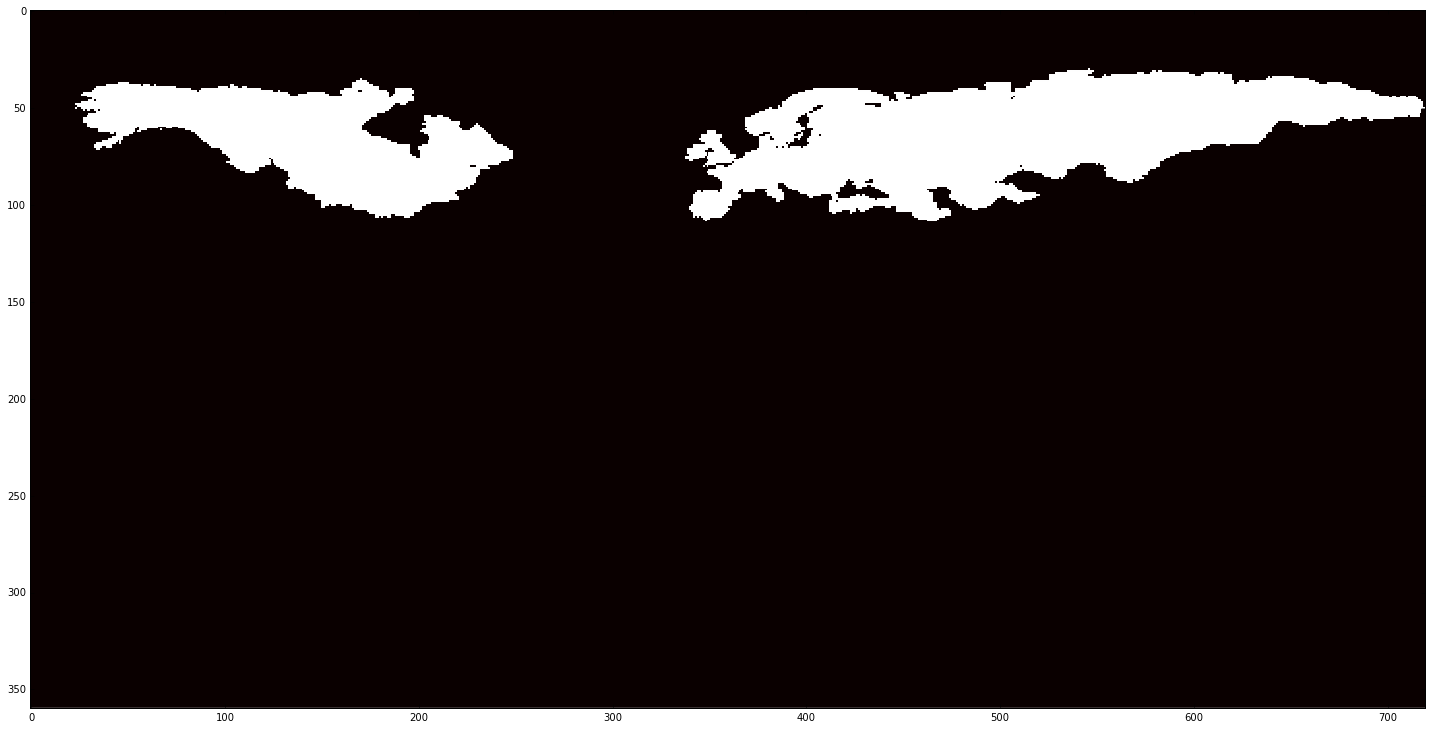

In [92]:
plt.figure(figsize=(25,20))
plt.imshow(rasterized_el, cmap="hot", interpolation="none")

In [93]:
selected_layers_el, pseudo_absences_el = biomes_adf.sample_pseudo_absences(species_raster_data=rasterized_el, continents_raster_data=continents_rasters, number_of_pseudopoints=1000)

Succesfully loaded existing raster data from ../data/rebioms/w001001.adf.
Will use the continents/biogeographic raster data for further clipping of the pseudo-absence regions. 
Sampling 1000 pseudo-absence points from environmental layer.
The following unique (pixel) values will be taken into account for sampling pseudo-absences
[ 7  8  9 10 11 12 13 14 15 16 17 21]
There are 25795 pixels to sample from...
Filling 1000 random pixel positions...
Sampled 980 unique pixels as pseudo-absences.


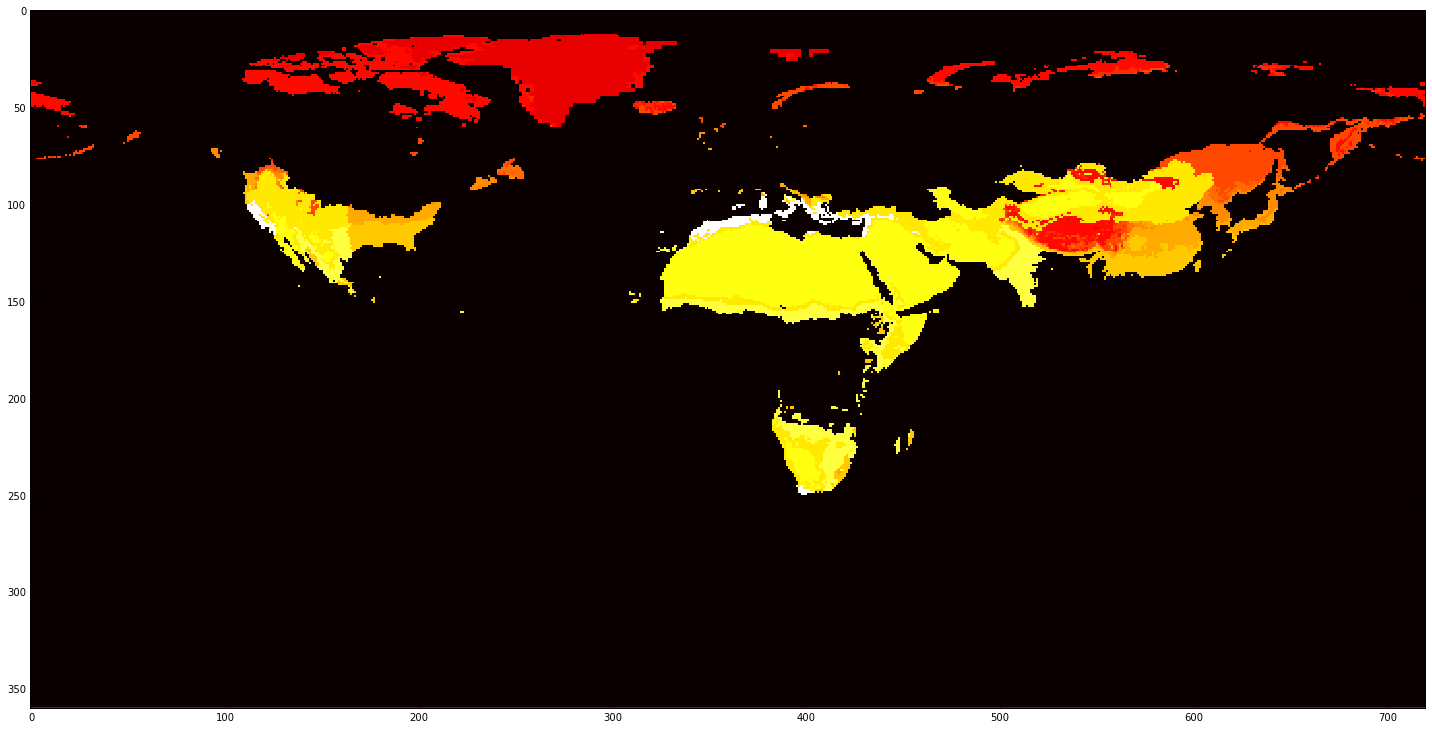

In [94]:
plt.figure(figsize=(25,20))
plt.imshow(selected_layers_el, cmap="hot", interpolation="none")

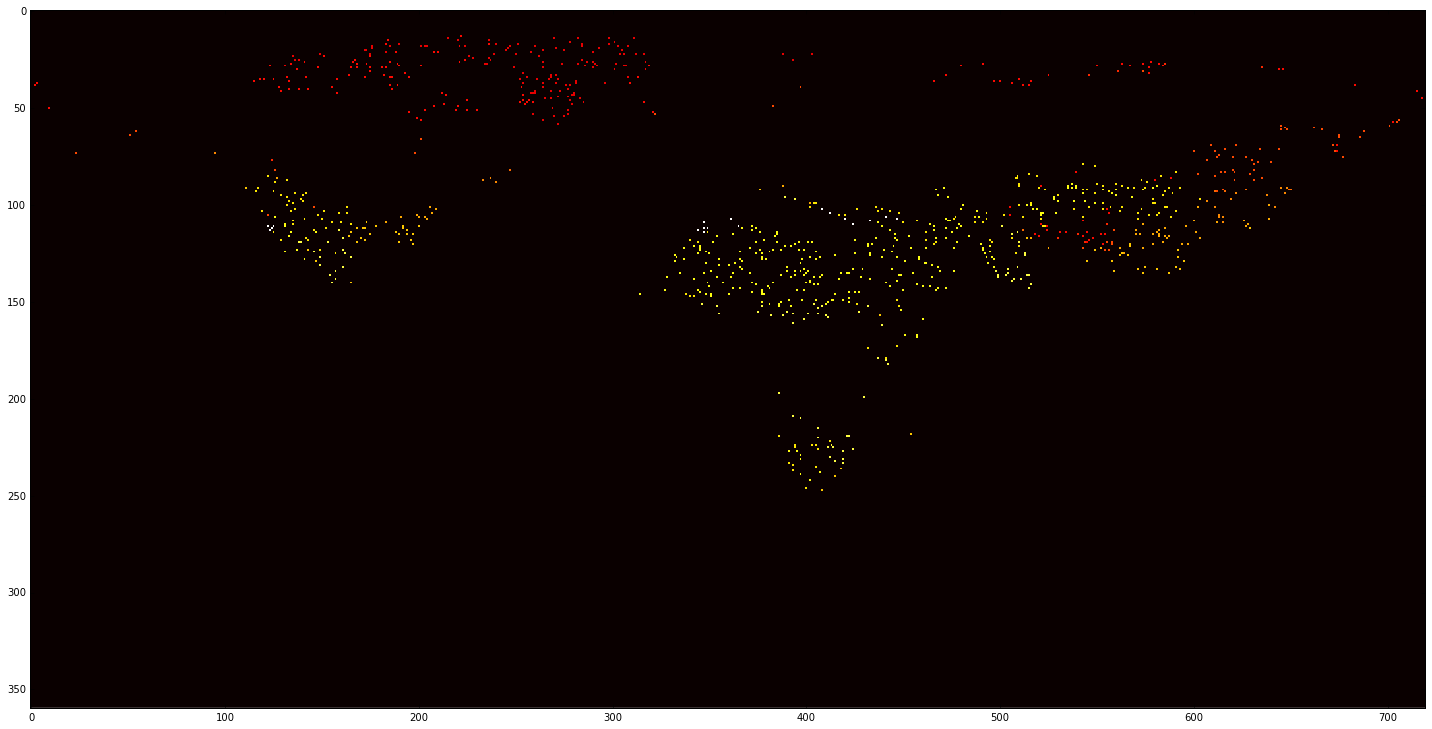

In [95]:
plt.figure(figsize=(25,20))
plt.imshow(pseudo_absences_el, cmap="hot", interpolation="none")

In [96]:
presence_coordinates_el = esox_lucius.pixel_to_world_coordinates()

No raster data provided, attempting to load default...
Loaded raster data from ./esox_lucius_full.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 360,
 'nodata': 0.0,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
Succesfully loaded existing raster data from ./esox_lucius_full.tif.
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.


In [97]:
presences_dataframe = pd.DataFrame([presence_coordinates_el[0], presence_coordinates_el[1]]).T
presences_dataframe.columns=['decimallatitude', 'decimallongitude']
presences_dataframe[esox_lucius.name_species] = 1 # fill presences with 1's
presences_dataframe.set_index(['decimallatitude', 'decimallongitude'], inplace=True, drop=True)
presences_dataframe.head()

Esox lucius
decimallatitude decimallongitude             
74.75           93.25                       1
74.25           87.75                       1
                88.25                       1
                88.75                       1
                89.25                       1

In [98]:
pseudo_absence_coordinates_el = biomes_adf.pixel_to_world_coordinates(raster_data=pseudo_absences_el)

Transforming to world coordinates...
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.
Transformation to world coordinates completed.


In [99]:
pseudo_absences_dataframe = pd.DataFrame([pseudo_absence_coordinates_el[0], pseudo_absence_coordinates_el[1]]).T
pseudo_absences_dataframe.columns=['decimallatitude', 'decimallongitude']
pseudo_absences_dataframe[esox_lucius.name_species] = 0 # fill pseudo-absences with 0
pseudo_absences_dataframe.set_index(['decimallatitude', 'decimallongitude'], inplace=True, drop=True)
pseudo_absences_dataframe.head()

Esox lucius
decimallatitude decimallongitude             
83.25           -68.75                      0
82.75           -72.25                      0
                -44.75                      0
                -38.75                      0
                -30.75                      0

In [100]:
merged2 = merged1.combine_first(presences_dataframe)

In [101]:
merged2.head()

Esox lucius  Lepidomeda mollispinis  \
decimallatitude decimallongitude                                        
-89.75          -179.75                   NaN                     NaN   
                -179.25                   NaN                     NaN   
                -178.75                   NaN                     NaN   
                -178.25                   NaN                     NaN   
                -177.75                   NaN                     NaN   

                                          MaxT         MeanT          MinT  \
decimallatitude decimallongitude                                             
-89.75          -179.75          -3.402823e+38 -3.402823e+38 -3.402823e+38   
                -179.25          -3.402823e+38 -3.402823e+38 -3.402823e+38   
                -178.75          -3.402823e+38 -3.402823e+38 -3.402823e+38   
                -178.25          -3.402823e+38 -3.402823e+38 -3.402823e+38   
                -177.75          -3.402823e+38 -3.402823e+38 -3.402823e+38   

                                  Salmo trutta  
decimallatitude decimallongitude                
-89.75          -179.75                    NaN  
                -179.25                    NaN  
                -178.75                    NaN  
                -178.25                    NaN  
                -177.75                    NaN

In [102]:
merged2 = merged2.combine_first(pseudo_absences_dataframe)

In [103]:
merged2.head()

Esox lucius  Lepidomeda mollispinis  \
decimallatitude decimallongitude                                        
-89.75          -179.75                   NaN                     NaN   
                -179.25                   NaN                     NaN   
                -178.75                   NaN                     NaN   
                -178.25                   NaN                     NaN   
                -177.75                   NaN                     NaN   

                                          MaxT         MeanT          MinT  \
decimallatitude decimallongitude                                             
-89.75          -179.75          -3.402823e+38 -3.402823e+38 -3.402823e+38   
                -179.25          -3.402823e+38 -3.402823e+38 -3.402823e+38   
                -178.75          -3.402823e+38 -3.402823e+38 -3.402823e+38   
                -178.25          -3.402823e+38 -3.402823e+38 -3.402823e+38   
                -177.75          -3.402823e+38 -3.402823e+38 -3.402823e+38   

                                  Salmo trutta  
decimallatitude decimallongitude                
-89.75          -179.75                    NaN  
                -179.25                    NaN  
                -178.75                    NaN  
                -178.25                    NaN  
                -177.75                    NaN

In [104]:
merged2['Esox lucius'].unique()

array([ nan,   0.,   1.])

In [105]:
merged2[merged2['Esox lucius']==0].shape # pseudo-absences

(980, 6)

In [106]:
merged2[merged2['Esox lucius']==1].shape # presences

(23715, 6)

In [107]:
merged2[merged2['Esox lucius'].isnull()].shape

(234505, 6)

In [108]:
merged2[merged2['Esox lucius'].isnull()].shape[0] + merged2[merged2['Esox lucius']==1].shape[0] + merged2[merged2['Esox lucius']==0].shape[0]

259200

In [109]:
merged2.tail()

Esox lucius  Lepidomeda mollispinis  \
decimallatitude decimallongitude                                        
89.75           177.75                    NaN                     NaN   
                178.25                    NaN                     NaN   
                178.75                    NaN                     NaN   
                179.25                    NaN                     NaN   
                179.75                    NaN                     NaN   

                                          MaxT         MeanT          MinT  \
decimallatitude decimallongitude                                             
89.75           177.75           -3.402823e+38 -3.402823e+38 -3.402823e+38   
                178.25           -3.402823e+38 -3.402823e+38 -3.402823e+38   
                178.75           -3.402823e+38 -3.402823e+38 -3.402823e+38   
                179.25           -3.402823e+38 -3.402823e+38 -3.402823e+38   
                179.75           -3.402823e+38 -3.402823e+38 -3.402823e+38   

                                  Salmo trutta  
decimallatitude decimallongitude                
89.75           177.75                     NaN  
                178.25                     NaN  
                178.75                     NaN  
                179.25                     NaN  
                179.75                     NaN

In [99]:
# rearange columns (nothing critical)

In [111]:
cols = merged2.columns.values
cols1 = [cols[4], cols[2], cols[3], cols[0], cols[1], cols[5]]

In [113]:
merged2 = merged2[cols1]

In [114]:
merged2.to_csv("../data/fish/selection/dataframe2.csv")

In [115]:
merged2.columns.values

array(['MinT', 'MaxT', 'MeanT', 'Esox lucius', 'Lepidomeda mollispinis',
       'Salmo trutta'], dtype=object)

In [116]:
merged2.head()

MinT          MaxT         MeanT  \
decimallatitude decimallongitude                                             
-89.75          -179.75          -3.402823e+38 -3.402823e+38 -3.402823e+38   
                -179.25          -3.402823e+38 -3.402823e+38 -3.402823e+38   
                -178.75          -3.402823e+38 -3.402823e+38 -3.402823e+38   
                -178.25          -3.402823e+38 -3.402823e+38 -3.402823e+38   
                -177.75          -3.402823e+38 -3.402823e+38 -3.402823e+38   

                                  Esox lucius  Lepidomeda mollispinis  \
decimallatitude decimallongitude                                        
-89.75          -179.75                   NaN                     NaN   
                -179.25                   NaN                     NaN   
                -178.75                   NaN                     NaN   
                -178.25                   NaN                     NaN   
                -177.75                   NaN                     NaN   

                                  Salmo trutta  
decimallatitude decimallongitude                
-89.75          -179.75                    NaN  
                -179.25                    NaN  
                -178.75                    NaN  
                -178.25                    NaN  
                -177.75                    NaN